In [1]:
import numpy as np
import cupy as cp
from scipy.special import  softmax
from cupyx.scipy.special import softmax as softmaxGPU
import matplotlib.pyplot as plt
import os
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle
import re
import glob
from importlib import reload
import modelBasedTrain as mb
import scipy.sparse as sparse
import time

In [2]:
SC = 92 * 131 # Number of States
M = 2
cSource = 45.5 # Source coordinates
rSource = 91
cols = 92
rows = 131
find_range = 1.1 # Source radius
gamma = 0.99975
reward = -(1 -gamma)
ActionDict = np.asarray([
            [-1,  0], # North
            [ 0,  1], # East
            [ 1,  0], # South
            [ 0, -1]  # West
        ])
dataC = np.load("celaniData/fine5.npy")
rho = np.zeros(SC * M)
rho[:cols] = (1-dataC[0,:cols])/np.sum((1-dataC[0,:cols]))
R = np.ones(SC*M) * -(1 - gamma)
for s in range(SC):
    r, c = s // 92, s % 92 
    if (r - rSource) ** 2 + (c -cSource) **2 < find_range**2:
        R[s::SC] = 0

In [3]:
def isEnd(sm):
    s = sm % SC
    r, c = s // cols, s % cols
    return (r +1 - rSource) ** 2 + (c +1 -cSource) **2 < find_range**2


def get_observation(sm, pObs):
    s = sm % SC
    return np.random.choice(2, p=pObs[:, s])

def choose_action(pi, o, M, curMem):
    return np.random.choice(4 * M, p = pi[o, curMem])

def takeAction(sm, am):
    s = sm % SC
    a = am % 4
    newM = am // 4
    r, c = s // cols, s % cols # forse usare unravel_index
    action = ActionDict[a]
    rNew = r + action[0]
    cNew = c + action[1]
    r = rNew if rNew >= 0 and rNew < 131 else r
    c = cNew if cNew >= 0 and cNew < 92 else c
    return r * 92 + c + newM * SC, newM

def getTraj(pi, pObs, rho):
    start = np.random.choice(range(131*92), size=1, p = rho[:SC]).astype(int)[0]
    obs = get_observation(start, pObs)
    curState = start
    curM = 0
    history = np.zeros((3, 10001)).astype(int)
    history[0, 0] = start
    history[1, 0] = obs
    t = 0
    while not isEnd(curState) and t < 10000:
        if curState == 8417 or curState == 8418 or curState == 20469 or curState == 20470:
            print("AAAAAA")
        action = choose_action(pi, obs, M, curM)
        history[2, t] = action
        newState, curM = takeAction(curState, action)
        obs = get_observation(newState, pObs)
        t += 1
        history[0, t] = newState
        history[1, t] = obs
        curState = newState
    return history, t

def plot_and_save(totIter, thetas, obj, normDiff, diffFromOpt, diffPrev, paramas, name, close = False):
    color = "orange"
    style = "--"
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"{name}\n Actor Lambda {paramas[1]}; Lr {paramas[3]}\nCritic Lambda {paramas[2]}; Lr {paramas[4]}; M {paramas[0]}")
    plt.subplot(2,2, 1)
    plt.plot(range(totIter), thetas, label = "Theta Norm")
    plt.legend()
    plt.subplot(2,2,2)
    plt.hlines(-0.48477305214190447, 0,totIter, "r", label = "Optimal M1")
    plt.hlines(-0.19, 0,totIter, "r", label = "~Optimal M2")
    plt.plot(range(totIter), obj, label = "Objective")
    plt.yticks([0, -0.1, -0.2, -0.3, -0.4,-0.48477305214190447, -0.5, -0.6, -0.7, -0.8, -0.9, -1])
    plt.grid()
    # plt.ylim(-1, -0.475)
    plt.legend()
    plt.subplot(2,2,3)
    plt.plot(range(totIter), normDiff, label = "Diff from True")
    plt.plot(range(totIter), diffFromOpt, label = "Diff from Optimal")
    plt.hlines(0, 0,totIter, "k", label= "0")
    plt.legend()
    plt.subplot(2,2,4)
    plt.plot(range(1, totIter), diffPrev[1:], label = "Diff from Prev")
    plt.hlines(0, 0,totIter, "k", label= "0")
    plt.legend()
    plt.savefig(f"objOut/png/{name}_{paramas}.png")
    if not close:
        plt.close()

In [68]:
reload(mb)

<module 'modelBasedTrain' from '/home/marchi/olfactory-navigation/experiments/FSC/modelBasedTrain.py'>

In [69]:
if M == 1:
    thOPt = np.load("results/modelBased/M1/celani/fine5/sparseCPUTest/theta_Conv8000.npy")
else:
    thOPt = np.load("celaniData/thetaLoroM2.npy")
s = time.perf_counter()
Vopt, eta = mb.sparse_T_CPU(softmax(thOPt, axis=2), dataC, rSource, cSource, find_range, R, rho, M)
e = time.perf_counter()
print(e-s, "Time")
Vopt @ rho

get 0.10187109932303429
AV 0.000807393342256546
Aeta 0.0013891048729419708
V 0.36372674629092216
eta 0.36766230314970016
0.8363250643014908 Time


-0.1977790976161042

In [83]:
piGPU = cp.asarray(softmax(thOPt, axis = 2))
pObsGPU = cp.asarray(dataC)
RGPU = cp.asarray(R)
rhoGPU = cp.asarray(rho)
print("AA")
s = time.perf_counter()
VG, etaG = mb.sparse_T_GPU(piGPU, pObsGPU, rSource, cSource, find_range, RGPU, rhoGPU, M)
e = time.perf_counter()
print(e-s)

AA
31.590935450047255


In [84]:
cp.dot(VG, rhoGPU)

array(-0.1977791)

In [8]:
th  = np.load("results/modelBased/M2/celani/fine5/alpha0.15_Rescale_Subtract/mb_2_2/theta_35000.npy")
softmax(th, axis = 2)

array([[[1.05101880e-36, 3.78053758e-01, 4.39318690e-64, 4.31070763e-01,
         1.80616625e-36, 1.42540545e-01, 7.18403496e-67, 4.83349344e-02],
        [8.10535426e-74, 9.80407867e-02, 1.41692277e-02, 1.12083001e-01,
         1.86924058e-72, 4.14780478e-01, 8.22069104e-04, 3.60104438e-01]],

       [[1.02633074e-59, 5.18927982e-40, 1.03026927e-01, 1.11919726e-36,
         9.88678534e-59, 3.74017103e-39, 8.96973073e-01, 1.18231882e-35],
        [8.62360631e-77, 3.24198416e-53, 6.75051298e-02, 2.71640456e-49,
         9.83449165e-76, 4.57711534e-52, 9.32494870e-01, 4.13554365e-48]]])

In [7]:
V = np.load("results/modelBased/M2/celani/fine5/alpha0.15_Rescale_Subtract/mb_2_2/V_35000.npy")
V @ rho

-0.8043757482946803

In [9]:
V2, eta = mb.sparse_T_CPU(softmax(th, axis = 2), dataC, rSource, cSource, 1.1, R, rho, 2)
print(np.allclose(V, V2))
print(V @ rho, V2 @ rho, np.dot(V, rho), np.dot(V2, rho), eta @ R)

TOT 106.3604904524982
True
-0.8043757482946803 -0.8043757482997032 -0.8043757482946803 -0.8043757482997032 -0.80437574829972


AAAAAA
AAAAAA
AAAAAA
2419


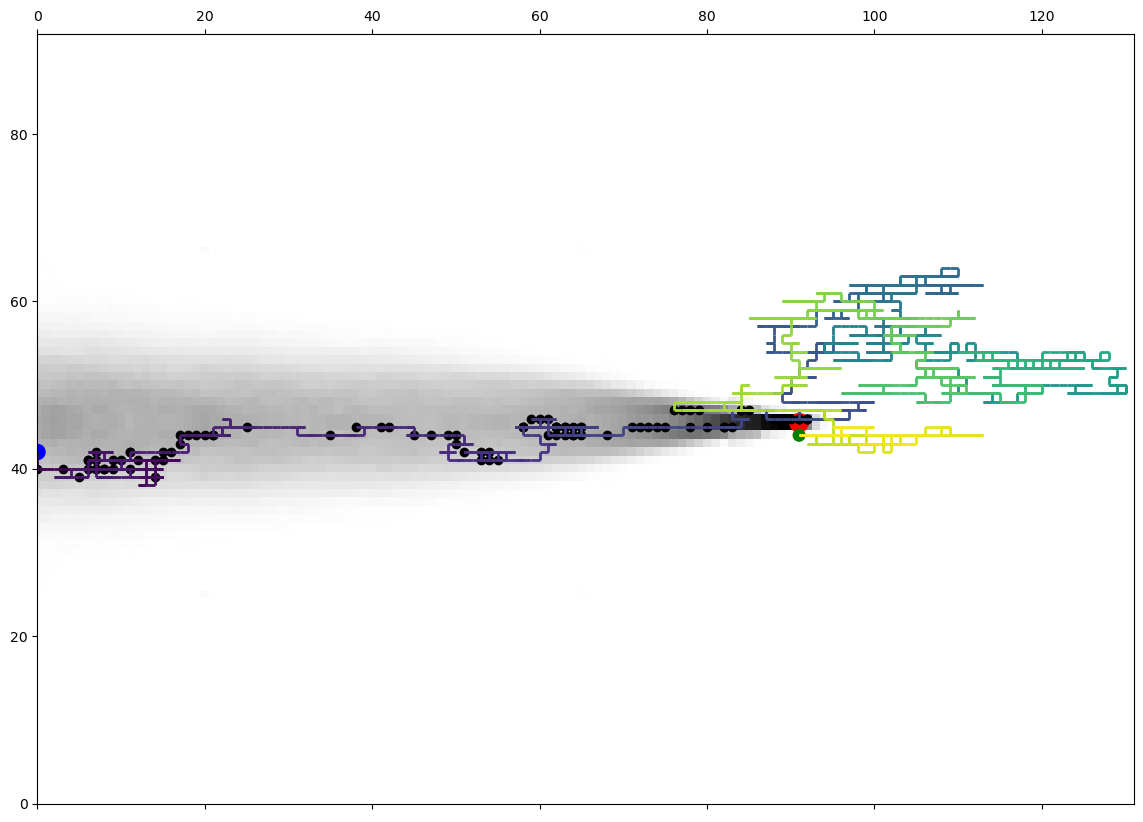

In [ ]:
hst, t = getTraj(softmax(th, axis = 2), dataC, rho)
print(t)
x, y = np.unravel_index(hst[0, :t] % SC, (131, 92))
pippo = np.linspace(0,1, len(x))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fig, ax = plt.subplots(figsize=(20,10))
lc = LineCollection(segments, cmap="viridis")
lc.set_linewidth(2)
lc.set_array(pippo)
line = ax.add_collection(lc)
ax.set_xlim([0,131])
ax.set_ylim([0,92])

ax.matshow(dataC.reshape((2,131,92))[1].T, cmap = "binary")
ax.add_patch(plt.Circle((91,45.5), 1.1, color="r"))
ax.add_patch(plt.Circle((x[0], y[0]), 0.9, color="b"))
ax.add_patch(plt.Circle((x[-1], y[-1]), 0.7, color="g"))
xObs = x[np.where(hst[1, :t])]
yObs = y[np.where(hst[1, :t])]
ax.scatter(xObs, yObs, c="k")

In [24]:
globDir = f"results/TD_Lambda/M2/lambda_actor*/lambda_critic*/alphaActor_*_Scheduled_alphaCritic_*_Scheduled/replicable_?_episodes_350000/"
parents = sorted(glob.glob(globDir))

for parentDir in parents:
    print(parentDir)
    reg = re.compile(f"results/TD_Lambda/M{M}/lambda_actor([01]\\.[0-9]*)/lambda_critic([01]\\.[0-9]*)/alphaActor_([0-9]+\\.[0-9]*)(?:_Scheduled)?_alphaCritic_([0-9]+\\.[0-9]*)(?:_Scheduled)?/(.*)/")
    print(reg.match(parentDir).groups())
len(parents)

results/TD_Lambda/M2/lambda_actor0.9/lambda_critic0.9/alphaActor_0.03_Scheduled_alphaCritic_0.1_Scheduled/replicable_0_episodes_350000/
('0.9', '0.9', '0.03', '0.1', 'replicable_0_episodes_350000')
results/TD_Lambda/M2/lambda_actor0.9/lambda_critic0.9/alphaActor_0.03_Scheduled_alphaCritic_0.1_Scheduled/replicable_1_episodes_350000/
('0.9', '0.9', '0.03', '0.1', 'replicable_1_episodes_350000')
results/TD_Lambda/M2/lambda_actor0.9/lambda_critic0.9/alphaActor_0.03_Scheduled_alphaCritic_0.1_Scheduled/replicable_2_episodes_350000/
('0.9', '0.9', '0.03', '0.1', 'replicable_2_episodes_350000')
results/TD_Lambda/M2/lambda_actor0.9/lambda_critic0.9/alphaActor_0.03_Scheduled_alphaCritic_0.1_Scheduled/replicable_3_episodes_350000/
('0.9', '0.9', '0.03', '0.1', 'replicable_3_episodes_350000')
results/TD_Lambda/M2/lambda_actor0.9/lambda_critic0.9/alphaActor_0.03_Scheduled_alphaCritic_0.1_Scheduled/replicable_4_episodes_350000/
('0.9', '0.9', '0.03', '0.1', 'replicable_4_episodes_350000')
results/TD

10

In [ ]:
parents = glob.glob(globDir)
for parentDir in parents:
    ls = glob.glob(parentDir+"Actors/theta*")
    totIter = len(ls) - (2 if parentDir + "Actors/thetaActorCriticFInale.npy" in ls else 1)
    minTh = int(re.search("theta([0-9]+).npy", min(ls)).group(1))
    reg = re.compile("results/TD_Lambda/M([0-9])/lambda_actor([01]\\.[0-9]*)/lambda_critic([01]\\.[0-9]*)/alphaActor_([0-9]+\\.[0-9]*)(?:_Scheduled)?_alphaCritic_([0-9]+\\.[0-9]*)(?:_Scheduled)?/(.*)/")
    gr = reg.match(parentDir).groups()
    print(f"{gr}")
    print(f"Actor Lambda {gr[1]}; M {gr[0]}; Lr {gr[3]}\nCritic Lambda {gr[2]}; Lr {gr[4]}; {gr[5]}")
    normDiff = np.zeros(totIter)
    diffFromOpt = np.zeros(totIter)
    obj = np.zeros(totIter)
    thetas = np.zeros(totIter)
    diffPrev = np.zeros(totIter)
    print(totIter)
    for i in range(0, totIter):
        th = np.load(parentDir + f"Actors/theta{minTh + i*1000}.npy")
        thetas[i] = np.linalg.norm(th)
        # T = mb.prova(softmax(th, axis = 2), dataC, rSource, cSource, find_range, M)
        # AV = sparse.eye(SC * M, format="csr") - gamma * T
        # trueV = sparse.linalg.spsolve(AV, R)
        trueV, _ = mb.sparse_T_CPU(softmax(th, axis = 2), dataC, rSource, cSource, find_range, R, rho, M)
        lambdaV = np.load(parentDir + f"Critics/critic{minTh + i*1000}.npy")
        obj[i] = np.dot(trueV, rho)
        normDiff[i] = np.linalg.norm(trueV - lambdaV, 2)
        diffFromOpt[i] = np.linalg.norm(lambdaV - Vopt, 2)
        if i > 0:
            diffPrev[i] = np.linalg.norm(lambdaV - prev)
        prev = lambdaV
    plot_and_save(totIter, thetas, obj, normDiff, diffFromOpt,diffPrev, gr[:5],gr[5] )    
    

2
('2', '0.9', '0.9', '0.03', '0.1', 'replicable_0_episodes_350000')
Actor Lambda 0.9; M 2; Lr 0.03
Critic Lambda 0.9; Lr 0.1; replicable_0_episodes_350000
350


KeyboardInterrupt: 

In [ ]:
np.where(rho != 0)

In [ ]:
trueV[np.where(rho != 0)]

In [ ]:
rho[rho != 0] * trueV[rho != 0]

In [ ]:
np.sum(rho[rho != 0] * trueV[rho != 0])

In [ ]:
np.where(R != R[0])

In [ ]:
softmax(thNew, axis = 2)

In [7]:
trueV, trueEta = mb.sparse_T_CPU(softmax(thNew, axis = 2), dataC, rSource, cSource, find_range, R, rho, 2)
a, b = np.dot(R, trueEta), np.dot(trueV, rho)
print(a, b, np.abs(a - b))

-0.1977790976161034 -0.1977790976161042 8.049116928532385e-16


In [ ]:
trueV, trueEta = mb.sparse_T_CPU(softmax(thOPt, axis = 2), dataC, rSource, cSource, find_range, R, rho, 2)
a, b = np.dot(R, trueEta), np.dot(trueV, rho)
print(a, b, np.abs(a - b))

In [ ]:
np.dot(trueV[:SC],rho[:SC]), np.dot(trueV[:SC],rho[SC:]), np.dot(trueV[SC:],rho[:SC]), np.dot(trueV[SC:],rho[SC:])

In [ ]:
pi = softmax(th, axis = 2)
pi[0, 0], pi[0, 1], pi[1, 0], pi[1, 1]

In [ ]:
a, b = np.dot(R, eta), np.dot(Vopt, rho)
print(a, b, np.abs(a - b))

In [ ]:
thOPt_1 = np.load("results/modelBased/M1/celani/fine5/sparseCPUTest/theta_Conv8000.npy")
pi_opt_1 = softmax(thOPt_1, axis = 2)
pi_opt_1

In [ ]:
pi_2 = np.zeros((2,2,8))
pi_2[0,:,:4] = pi_opt_1[0]
pi_2[1,:,:4] = pi_opt_1[1]
pi_2

In [ ]:
T_2_opt = mb.get_Transition_Matrix_sparse_CPU(softmax(thOPt,axis = 2), dataC, rSource, cSource, find_range, 2).toarray()
T_2_new = mb.get_Transition_Matrix_sparse_CPU(softmax(thNew, axis = 2), dataC, rSource, cSource, find_range, 2).toarray()

In [ ]:
np.count_nonzero(~np.isclose(T_2_opt, T_2_new))

In [ ]:
SC*2

In [ ]:
np.where(~(np.abs(T_2_new[:SC] - T_2_opt[:SC] < 1e-2)))

In [ ]:
T_2_new[0, 12144], T_2_opt[0,12144]

In [ ]:
i,j = SC + 19, 20
T_2[i, j], T_1_opt[i % SC, j], T_2[i, j] - T_1_opt[i % SC, j]

In [ ]:
pippo = np.random.randint(10, size=(4,4))
pippo, pippo[:2, :2], pippo[:2, 2:], pippo[2:, :2], pippo[2:, 2:]

In [ ]:
np.where(~np.isclose(T_2[SC:, SC:], np.zeros((SC, SC))))

In [ ]:
np.unravel_index(np.argmax(np.abs(T_2[:SC, :SC] - T_2[SC:, :SC])), (SC, SC))

In [ ]:
T_2[18, 19], T_1_opt[18, 19], T_2[18, 19] - T_1_opt[18, 19]

In [ ]:
pi_2[:, 1, :4] - pi_opt_1.reshape((2,4))

In [ ]:
np.where(~np.isclose(T_2[SC:, SC:], 0))

In [ ]:
T_2[8418, 8418], T_2[SC + 8418, 8418]

In [ ]:
tempFinal = [s for s in range(SC) if (s // 92 - rSource) ** 2 + (s % 92 -cSource) **2 < find_range**2 ]
final = tempFinal.copy()
for i in range(1, M):
    final += [f + i * SC for f in tempFinal]
final

In [ ]:
rowIdx = np.array(range(8*M)).repeat(4*M)
rowIdx

In [ ]:
toSum = np.sum(pi_2[None, :, :, :].T * dataC[:, :], axis = 2).T.reshape(-1)
toSum.shape, SC*2*4 * 2

In [ ]:
np.allclose(np.sum(T_1_opt, axis = 1),1)

In [ ]:
R[R!= R[0]]

In [ ]:
V, eta = mb.sparse_T_CPU(pi_2, dataC, rSource, cSource, find_range, R, rho, 2)

In [ ]:
np.dot(R, eta), np.dot(V, rho)

In [ ]:
np.count_nonzero(eta[SC:])

In [ ]:
tmp = eta[:SC]
tmp[tmp > 5] = 0
plt.matshow(tmp.reshape((rows, cols)))

In [ ]:
np.where(pippo > 6), pippo[8417]

In [ ]:
# np.count_nonzero(np.isclose(eta, tmp))
pippo = etaNew[SC:-cols]
pippo[8417] = 0
pippo[8418] = 0
plt.matshow(pippo.reshape((rows-1, cols)))
plt.colorbar()

In [ ]:
import scipy.sparse as sparse

In [ ]:
AV = sparse.eye(SC * M, format="csr") - gamma * T_2[:SC, :SC]
Aeta = sparse.eye(SC * M, format="csr") - gamma * T_2[:SC, :SC].T
V = sparse.linalg.spsolve(AV, R)
eta = sparse.linalg.spsolve(Aeta, rho)
np.dot(R, eta), np.dot(V, rho)

In [ ]:
def getReachable(s, M):
    r, c, m = (s % SC) // 92, s % 92 , s // SC
    # print(r, c)
    stateInMem0 = r * 92 + c
    ret = np.zeros(4 * M, dtype = int)
    for i in range(M):
        ret[0 + i *4] = stateInMem0 - 92 + SC * i if r - 1 >= 0 else  stateInMem0 + SC * i
        ret[1 + i *4] = stateInMem0 + 1  + SC * i if c + 1 < 92 else  stateInMem0 + SC * i
        ret[2 + i *4] = stateInMem0 + 92 + SC * i if r + 1 < 131 else stateInMem0 + SC * i
        ret[3 + i *4] = stateInMem0  -1  + SC * i if c - 1 >= 0 else  stateInMem0 + SC * i
    return ret

In [ ]:
getReachable(SC+cols-1,2)

In [ ]:
new_T_1 = np.zeros((SC, SC))
for i in range(SC):
    for a, j in enumerate(getReachable(i, 1)):
        new_T_1[i, j] += pi_opt_1[0, 0, a] * dataC[0, i] + pi_opt_1[1, 0, a] * dataC[1, i]
new_T_1[8417, :] = 0
new_T_1[8418, :] = 0
new_T_1[8417, 8417] = 1
new_T_1[8418, 8418] = 1
np.allclose(T_1_opt, new_T_1)

In [ ]:
pi_2_opt = softmax(np.load("celaniData/thetaLoroM2.npy"), axis = 2)
pi_2_opt

In [ ]:
new_T_2 = np.zeros((SC*M, SC*M))
for i in range(SC*M):
    m = i // SC
    s = i % SC
    for a, j in enumerate(getReachable(i, 2)):
        new_T_2[i, j] += pi_2[0, m, a] * dataC[0, s] + pi_2[1, m, a] * dataC[1, s]
new_T_2[8417, :] = 0
new_T_2[8418, :] = 0
new_T_2[8417 +SC, :] = 0
new_T_2[8418 +SC, :] = 0
new_T_2[8417, 8417] = 1
new_T_2[8418, 8418] = 1
new_T_2[8417 + SC, 8417 + SC] = 1
new_T_2[8418 + SC, 8418 + SC] = 1
np.allclose(T_1_opt, new_T_2[:SC, :SC])

In [ ]:
np.where(~np.isclose(new_T_1, T_1_opt))

In [ ]:
T_1_opt[12051, 12051], new_T_1[12051, 12051]

In [ ]:
getReachable(0, 1)

In [ ]:
np.unravel_index(12051, (rows, cols))

In [ ]:
np.where(~np.isclose(T_2[:SC, :SC], new_T_2[:SC, :SC]))

In [ ]:
invTnew = np.linalg.inv(np.eye(SC*2) - gamma * T_2_new)

In [ ]:
Vnew = R @ invTnew.T
eta = invTnew.T @ rho

In [ ]:
np.dot(Vnew, rho), np.dot(R, eta)

In [ ]:
tmp = eta[:SC]
tmp[8417] = 0
tmp[8418] = 0
plt.matshow(tmp.reshape((rows, cols)))

In [ ]:
th1 = np.load("results/modelBased/M1/celani/fine5/sparseCPUTest/theta_Conv8000.npy")
pi1 = softmax(th1, axis = 2)
V, eta = mb.sparse_T_CPU(softmax(th1, axis = 2), dataC, rSource, cSource, find_range, R[:SC], rho[:SC], 1)

In [ ]:
pi2 = softmax(thNew, axis = 2)

In [ ]:
(pi1[None, :, :, :].T * dataC[:, :])[3, 0, 0, 8417 -cols], pi1[0,0,3] * dataC[0, 8417 -cols]

In [ ]:
dataC[1, 8417 - cols]

In [ ]:
pi2

In [ ]:
toSum = np.sum(pi2[None, :, :, :].T * dataC[:, :], axis = 2).T.reshape(-1)
toSum.shape

In [ ]:
toSum[:8]

In [ ]:
rowIdx = np.array(range(SC*M)).repeat(4*M)
rowIdx[8417 * 8: 8418 * 8]

In [ ]:

from itertools import chain
from itertools import repeat as itReapeat
def getReachable(s, M):
    r, c, m = (s % SC) // 92, s % 92 , s // SC
    stateInMem0 = r * 92 + c
    ret = np.zeros(4 * M, dtype = int)
    for i in range(M):
        ret[0 + i *4] = stateInMem0 - 92 + SC * i if r - 1 >= 0 else  stateInMem0 + SC * i
        ret[1 + i *4] = stateInMem0 + 1  + SC * i if c + 1 < 92 else  stateInMem0 + SC * i
        ret[2 + i *4] = stateInMem0 + 92 + SC * i if r + 1 < 131 else stateInMem0 + SC * i
        ret[3 + i *4] = stateInMem0  -1  + SC * i if c - 1 >= 0 else  stateInMem0 + SC * i
    return ret

In [ ]:
colIdx = np.array(list(chain.from_iterable(map(getReachable, range(SC*M), itReapeat(M))))) 

In [ ]:
colIdx[8417 * 8:8418 * 8]

In [ ]:
reload(mb)

In [ ]:
pi2

In [ ]:
toSum, rowIdx, colIdx = mb.get_Transition_Matrix_sparse_CPU(pi2, dataC, rSource, cSource, find_range, 2)

In [ ]:
toSum[(SC + 8325) * 8:(SC + 8326)*8], np.sum(toSum[(SC + 8325) * 8:(SC + 8326)*8]), rowIdx[(SC + 8325) * 8:(SC + 8326)*8], colIdx[(SC + 8325) * 8:(SC + 8326)*8], dataC[1, 8325]

In [ ]:
toSum1, rowIdx1, colIdx1 = mb.get_Transition_Matrix_sparse_CPU(pi1, dataC, rSource, cSource, find_range, 1)

In [ ]:
pi1

In [ ]:
toSum1[(8325) * 4:(8326)*4], np.sum(toSum1[(8325) * 4:(8326)*4]), rowIdx1[(8325) * 4:(8326)*4], colIdx1[(8325) * 4:(8326)*4], dataC[0, 8325]

In [ ]:
scemo = np.array(range(4 * 2* 2)).reshape((2,2,4))
scemo[0, 0, 0] = 100
scemo[None, :, :, :].T, scemo

In [ ]:
pippo = np.array([[0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]).T
pippo

In [ ]:
pi = softmax(thNew, axis = 2)
pi

In [ ]:
reload(mb)

In [ ]:
T_sparse = mb.get_Transition_Matrix_sparse_CPU(pi1, dataC, rSource, cSource, find_range, 1).toarray()
T_naive = mb.prova(pi1, dataC, rSource, cSource, find_range, 1)

In [ ]:
pippo = np.where(~np.isclose(T_sparse, T_naive))

In [ ]:
pippo

In [ ]:
pi

In [ ]:
h = SC *5

In [ ]:
h += 1
i,j = pippo[0][h], pippo[1][h]
i,j, i % SC, j % SC

In [ ]:
T_sparse[i,j], T_naive[i,j], dataC[0, i % SC], dataC[1, i % SC], dataC[0,i % SC] * pi[0,i // SC] + dataC[1,i % SC] * pi[1,i // SC]

In [ ]:
plt.matshow(dataC[0].reshape((rows, cols)))

In [ ]:
T_naive[8417] = 0
T_naive[8418] = 0
T_naive[8417 + SC] = 0
T_naive[8418 + SC] = 0
T_naive[8417, 8417] = 1
T_naive[8418, 8418] = 1
T_naive[8417 + SC, 8417 + SC] = 1
T_naive[8418 + SC, 8418 + SC] = 1

In [ ]:
np.allclose(np.sum(T_naive, axis = 1),1)

In [ ]:
TnaiveInv = np.linalg.inv(np.eye(SC * 2) - gamma * T_naive)

In [ ]:
Vnaive = R @ TnaiveInv.T
etaNaive = TnaiveInv.T @ rho

In [ ]:
R @ etaNaive, Vnaive @ rho 

In [ ]:
np.argmax(tmp)

In [ ]:
tmp = etaNaive[:SC]
# tmp[:cols] = 0
tmp[8417] = 0
tmp[8418] = 0
plt.matshow(Vnaive[SC:].reshape((rows, cols)))

In [ ]:
t = 0
s = 45
while s != 8417 and t < 1000:
    s += cols
    t += 1
print(t, s)

/tmp/ipykernel_398828/2846822007.py:4: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 3500))


(2.1196765134827134, 3500)

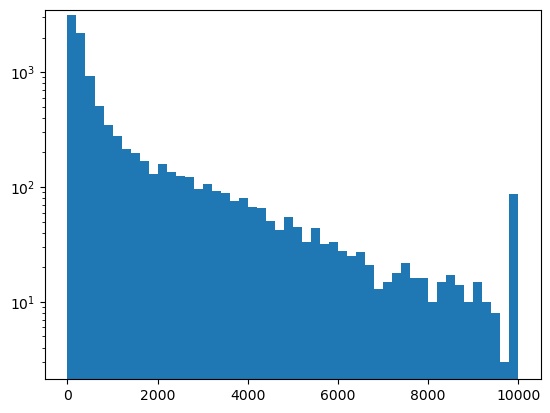

In [23]:
m2_loro_plusOne = np.load("eval/results/m2_loro_normal.npy")
plt.hist(m2_loro_plusOne, 50, range = (0, 10000));
plt.yscale("log")
plt.ylim((0, 3500))

/tmp/ipykernel_398828/3498605769.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 3500))


(2.1196765134827134, 3500)

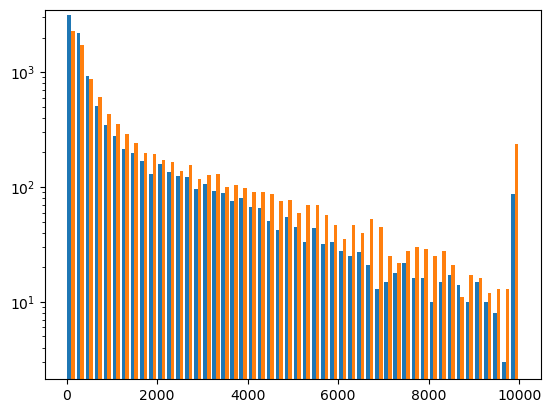

In [25]:
m2_loro_normal = np.load("eval/results/m2_loro_normal.npy")
# plt.hist(m2_loro_plusOne, 50, range = (0, 10000));
m2_loro_plusOne = np.load("eval/results/m2_loro_plusOne.npy")
plt.hist([m2_loro_normal, m2_loro_plusOne], 50, range = (0, 10000));
plt.yscale("log")
plt.ylim((0, 3500))

In [201]:
aa.shape

(8, 2, 1, 4)

In [210]:
a = np.load("results/modelFree/M1/row0/maxIt_1000/10000/shapingFree_0.1/theta_START.npy")
aa = np.array([np.copy(a) for i in range(2*4)])
for i in range(2*4):
    aa[i][i//4,0,i%4] += 0.1

sa = softmax(aa,axis = 3)
sb = softmax(aa -np.max(aa, axis = 3, keepdims=True), axis = 3)
m = -np.inf
for i in range(8):
    for j in range(i+1, 8):
        tmp = np.max(np.abs(sa[i] - sa[j]))
        if m < tmp:
            m = tmp
m, np.allclose(sa, sb)

(0.030245738210663342, True)

In [25]:
softmax(bb, axis = 1)

array([[1.00000000e+00, 6.30511676e-16, 6.30511676e-16, 6.30511676e-16],
       [9.93307145e-01, 6.69285090e-03, 2.04735862e-09, 2.04735862e-09],
       [9.93307145e-01, 2.04735862e-09, 6.69285090e-03, 2.04735862e-09],
       [9.93307145e-01, 2.04735862e-09, 2.04735862e-09, 6.69285090e-03]])

In [22]:
obj = []
f = open("results/modelBased/M3/celani/fine5/alpha0.1_Rescale_Subtract/mb_3/output.out")
for l in f:
    if "Obj" in l:
        obj.append(float(l.split(" ")[-1]))

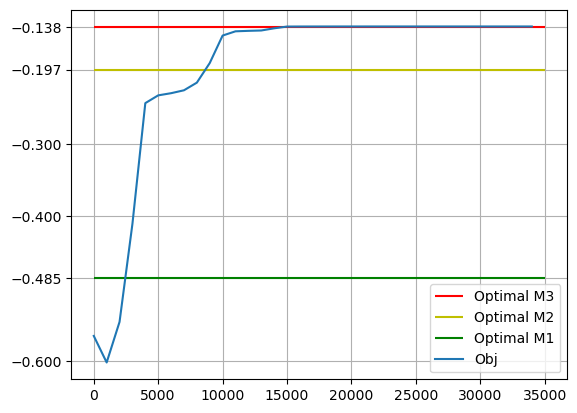

In [23]:
M = 3
maxIt = 35000
ticks = [0, -0.1, -0.3, -0.4,-0.485, -0.6, -0.7, -0.8, -0.9, -1]
if M == 3:
    plt.hlines(-0.138, 0,maxIt, "r", label = f"Optimal M3")
    ticks += [-0.138]
if M >= 2:
    ticks += [-0.197]
    plt.hlines(-0.197, 0,maxIt, "y", label = f"Optimal M2")
else:
    ticks += [-0.2]
plt.hlines(-0.485, 0,maxIt, "g", label = f"Optimal M1")
plt.yticks(ticks)
plt.plot(range(1,maxIt+1, 1000), obj, label = "Obj")
plt.legend()
plt.grid()
plt.savefig("objOut/png/modelBased/mb_3_0.1_r_s.png")